# Model selection for predicting `IN_LEAGUE_NEXT`

In this notebook we perform model selection with the goal of generating the best classifier for the response variable `IN_LEAGUE_NEXT`, whether or not a given player will play at any point in the next NBA season (and thus have stats data).

We will do all model selection using _only_ the set of training data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Load the data

_Note:_ we don't have `IN_LEAGUE_NEXT` data for the 2023 season (because we still don't know if a given player will play _at any point_ in the 2024 season).  As a result, we have to restrict our data to `SEASON_START` before 2023.

In [2]:
#load the data
df_train = pd.read_csv("Data/merged_data/train_data.csv")

#NOTE: we don't have IN_LEAGUE_NEXT data for SEASON_START = 2023 and drop nan rows
df_train = df_train[df_train.SEASON_START < 2023].dropna()

## Correlations

Now we'll look at correlations between the predictors and the response variable.  Below we grab the numeric columns and make a correlation heatmap before printing the correlations with `IN_LEAGUE_NEXT`.

In [3]:
#grab all columns
all_cols = list(df_train.columns)

#grab just the columns with numeric data
num_cols = [all_cols[2]] + all_cols[4:6] + all_cols[7:]

#grab just the predictors for later
predictors = num_cols[:-1]

IN_LEAGUE_NEXT    1.000000
GP                0.462373
MIN               0.427752
PF                0.425080
WAIVED            0.383255
FGM               0.372937
FGA               0.372071
PTS               0.368640
TOV               0.359772
DREB              0.357740
REB               0.353179
STL               0.352597
DWS               0.346434
WAIVED_REG        0.345849
WS                0.335903
Name: IN_LEAGUE_NEXT, dtype: float64

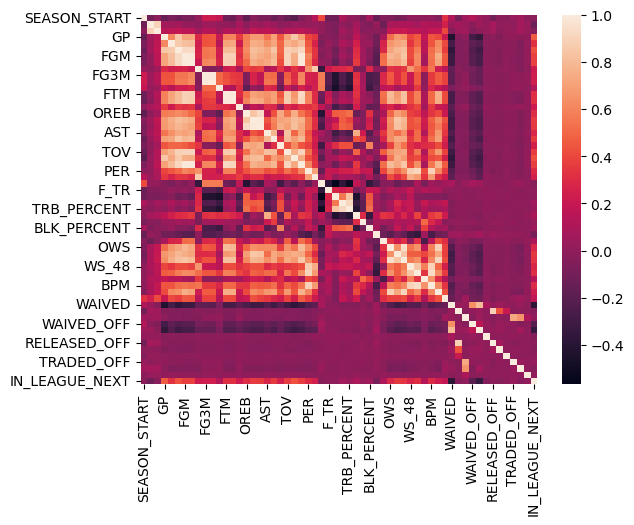

In [4]:
#compute correlations between numeric data columns
corr = df_train[num_cols].corr()

#plot heatmap
sns.heatmap(corr)

#print top 15 or so |correlations| with IN_LEAGUE_NEXT in descending order
abs(corr["IN_LEAGUE_NEXT"]).sort_values(ascending=False)[0:15]

# Modeling

## Model 1: Naive logistic regression model

Let's begin by finding the 5-fold CV performance of a simple logistic regression model on the training set.

The primary metric we'll use to score the model's performance is the _balanced accuracy score_ (https://scikit-learn.org/dev/modules/model_evaluation.html#balanced-accuracy-score), which generalizes the accuracy score to imbalanced classes (which is the case here; see the cell immediately below).

In [5]:
#show that we have imbalanced classes
df_train.IN_LEAGUE_NEXT.value_counts(normalize=False)

IN_LEAGUE_NEXT
1.0    9575
0.0    2078
Name: count, dtype: int64

In [6]:
#import the functions we need for modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [7]:
def compute_metrics(true_y_vals, predictions):
    """Compute metrics given true y values and classifier predictions.
       Returns a list with the following components: balanced accuracy 
       score, precision, recall, negative predictive value, and specificity."""
    
    #get the confusion matrix
    conf      = confusion_matrix(true_y_vals, predictions)
    
    #grab true negatives, true positives, false positives, false negatives
    tn = conf[0,0]
    tp = conf[1,1]
    fp = conf[0,1]
    fn = conf[1,0]

    #balanced accuracy score
    bal_accuracy = balanced_accuracy_score(true_y_vals, predictions)
    #precision (positive predictive value): what % of players classified as 1's are true 1's?
    precision    = tp/(tp+fp)
    #recall (sensitivity): what % of true 1's are classified as 1?
    recall       = tp/(tp+fn)
    #negative predictive value (NPV): what % of players classified as 0's are true 0's?
    npv          = tn/(tn+fn)
    #specificity: what % of true 0's are classified as 0?
    specificity  = tn/(tn+fp)


    return np.array([bal_accuracy, precision, recall, npv, specificity])

CV fold 0 complete
CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete

Metrics for the naive Logistic Regression Model
Avg bal. accuracy: 0.699
Avg precision:     0.888
Avg recall:        0.951
Avg NPV:           0.663
Avg specificity:   0.447


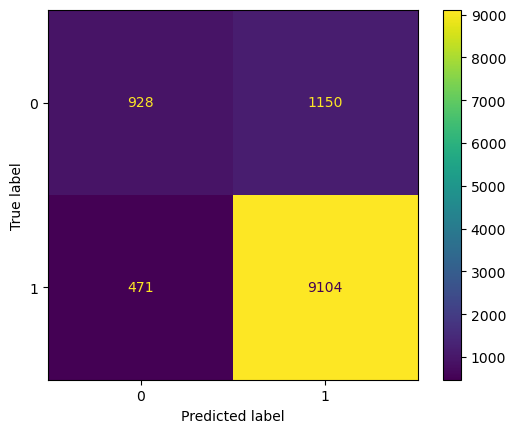

In [8]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=815)

metrics = []

conf_matrices = []

for i, (train_idx, test_idx) in enumerate(kfold.split(df_train[predictors], df_train.IN_LEAGUE_NEXT)):
    #grab the raw training data and test data for this CV fold
    X_tt  = df_train[predictors].iloc[train_idx]
    y_tt  = df_train.IN_LEAGUE_NEXT.iloc[train_idx]
    X_val = df_train[predictors].iloc[test_idx]
    y_val = df_train.IN_LEAGUE_NEXT.iloc[test_idx]

    #train the model
    lr = Pipeline([("scale", StandardScaler()), ("log-reg", LogisticRegression(penalty=None, max_iter=10_000))])
    lr.fit(X_tt, y_tt)
    
    #get prediction and balanced accuracy scores for validation set
    pred = lr.predict(X_val)

    #compute metrics and append them to list
    metrics.append(compute_metrics(y_val, pred))

    #compute confusion matrix and append it to a list
    conf_matrices.append(confusion_matrix(y_val, pred))

    print(f"CV fold {i} complete")

#print CV averaged metrics, confusion matrix summed over all CV folds
avg_bal_acc, avg_prec, avg_recall, avg_npv, avg_spec = np.mean(np.array(metrics), axis=0)
full_conf_matrix                                     = np.sum(conf_matrices, axis=0)

print("\n" + "Metrics for the naive Logistic Regression Model")
print(f"Avg bal. accuracy: {avg_bal_acc:.3f}")
print(f"Avg precision:     {avg_prec:.3f}")
print(f"Avg recall:        {avg_recall:.3f}")
print(f"Avg NPV:           {avg_npv:.3f}")
print(f"Avg specificity:   {avg_spec:.3f}")

ConfusionMatrixDisplay(full_conf_matrix).plot()

## Model 2: Logistic regression model trained on balanced classes

We'll now address the fact that our classes are imbalanced by augmenting the training data used in each CV fold.  To do so, we'll use the `imblearn` library's data augmentation functions.  Of these functions, I find that the Synthetic Minority Oversampling Technique (SMOTE) gives the best performance.

In [9]:
#import SMOTE
from imblearn.over_sampling import SMOTE

CV fold 0 complete
CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete

Metrics for the SMOTE Logistic Regression Model
Avg bal. accuracy: 0.772
Avg precision:     0.923
Avg recall:        0.883
Avg NPV:           0.552
Avg specificity:   0.661


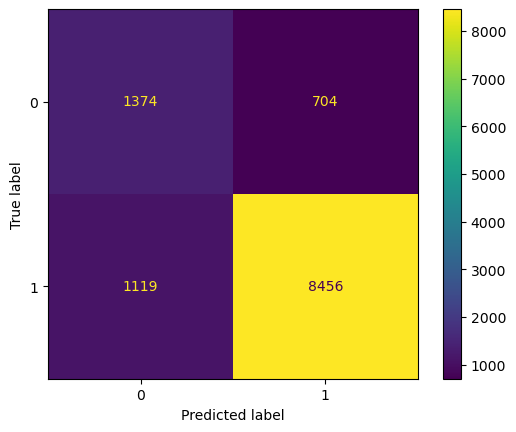

In [10]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=815)

metrics = []

conf_matrices = []

for i, (train_idx, test_idx) in enumerate(kfold.split(df_train[predictors], df_train.IN_LEAGUE_NEXT)):
    #grab the raw training data and test data for this CV fold
    X_tt  = df_train[predictors].iloc[train_idx]
    y_tt  = df_train.IN_LEAGUE_NEXT.iloc[train_idx]
    X_val = df_train[predictors].iloc[test_idx]
    y_val = df_train.IN_LEAGUE_NEXT.iloc[test_idx]

    #resample the training data using SMOTE
    smote = SMOTE(random_state=5)
    X_tt_re, y_tt_re = smote.fit_resample(X_tt, y_tt)

    #train the model
    lr = Pipeline([("scale", StandardScaler()), ("log-reg", LogisticRegression(penalty=None, max_iter=10_000))])
    lr.fit(X_tt_re, y_tt_re)
    
    #get prediction and balanced accuracy scores for validation set
    pred = lr.predict(X_val)

    #compute metrics and append them to list
    metrics.append(compute_metrics(y_val, pred))

    #compute confusion matrix and append it to a list
    conf_matrices.append(confusion_matrix(y_val, pred))

    print(f"CV fold {i} complete")

#print CV averaged metrics
avg_bal_acc, avg_prec, avg_recall, avg_npv, avg_spec = np.mean(np.array(metrics), axis=0)
full_conf_matrix                                     = np.sum(conf_matrices, axis=0)

print("\n" + "Metrics for the SMOTE Logistic Regression Model")
print(f"Avg bal. accuracy: {avg_bal_acc:.3f}")
print(f"Avg precision:     {avg_prec:.3f}")
print(f"Avg recall:        {avg_recall:.3f}")
print(f"Avg NPV:           {avg_npv:.3f}")
print(f"Avg specificity:   {avg_spec:.3f}")

ConfusionMatrixDisplay(full_conf_matrix).plot()

### SMOTE-balanced training data gives improved performance.

Notice that the performance is about 10% better in terms of the balanced accuracy score, simply by training the model with a set of augmented data (from SMOTE).  That said, we have noticeably more false negatives after augmenting the data.

## Models 3a-b: Linear Discriminant Analysis, Naive Bayes Classifier

Here we will try a couple more classifiers in much the same way as above.  Specifically, we use Linear Discriminant Analysis (LDA) and the Naive Bayes Classifier.  

We do not use Quadratic Discriminant Analysis because many of our predictors are collinear, and the algorithm does not converge well; we could use PCA beforehand, but I find that the performance is still worse than LDA and Naive Bayes.

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

CV fold 0 complete
CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete

Metrics for the SMOTE LDA Model
Avg bal. accuracy: 0.763
Avg precision:     0.918
Avg recall:        0.897
Avg NPV:           0.571
Avg specificity:   0.629


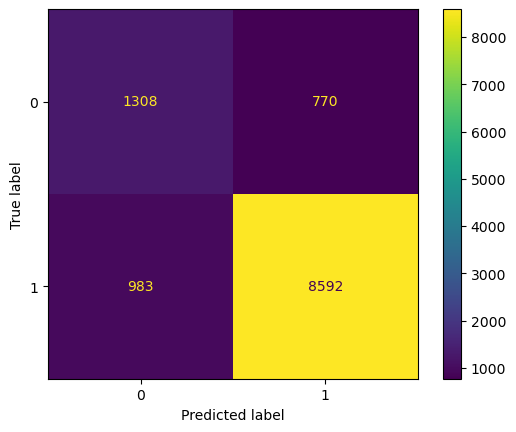

In [12]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=815)

metrics = []

conf_matrices = []

for i, (train_idx, test_idx) in enumerate(kfold.split(df_train[predictors], df_train.IN_LEAGUE_NEXT)):
    #grab the raw training data and test data for this CV fold
    X_tt  = df_train[predictors].iloc[train_idx]
    y_tt  = df_train.IN_LEAGUE_NEXT.iloc[train_idx]
    X_val = df_train[predictors].iloc[test_idx]
    y_val = df_train.IN_LEAGUE_NEXT.iloc[test_idx]

    #resample the training data using SMOTE
    smote = SMOTE(random_state=5)
    X_tt_re, y_tt_re = smote.fit_resample(X_tt, y_tt)

    #train the model
    lda = Pipeline([("scale", StandardScaler()), ("lda", LinearDiscriminantAnalysis())])
    lda.fit(X_tt_re, y_tt_re)
    
    #get prediction and balanced accuracy scores for validation set
    pred = lda.predict(X_val)

    #compute metrics and append them to list
    metrics.append(compute_metrics(y_val, pred))

    #compute confusion matrix and append it to a list
    conf_matrices.append(confusion_matrix(y_val, pred))

    print(f"CV fold {i} complete")

#print CV averaged metrics
avg_bal_acc, avg_prec, avg_recall, avg_npv, avg_spec = np.mean(np.array(metrics), axis=0)
full_conf_matrix                                     = np.sum(conf_matrices, axis=0)

print("\n" + "Metrics for the SMOTE LDA Model")
print(f"Avg bal. accuracy: {avg_bal_acc:.3f}")
print(f"Avg precision:     {avg_prec:.3f}")
print(f"Avg recall:        {avg_recall:.3f}")
print(f"Avg NPV:           {avg_npv:.3f}")
print(f"Avg specificity:   {avg_spec:.3f}")

ConfusionMatrixDisplay(full_conf_matrix).plot()

CV fold 0 complete
CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete

Metrics for the SMOTE Naive Bayes Model
Avg bal. accuracy: 0.776
Avg precision:     0.961
Avg recall:        0.679
Avg NPV:           0.371
Avg specificity:   0.872


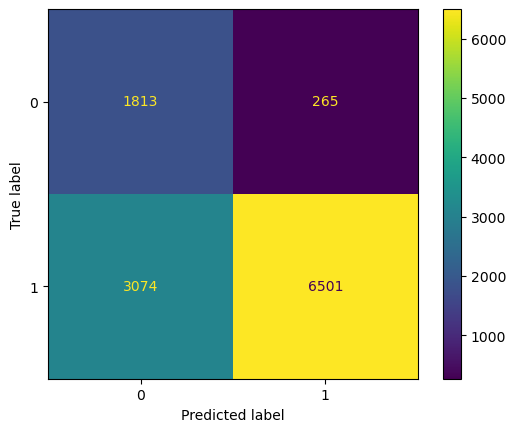

In [13]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=815)

metrics = []

conf_matrices = []

for i, (train_idx, test_idx) in enumerate(kfold.split(df_train[predictors], df_train.IN_LEAGUE_NEXT)):
    #grab the raw training data and test data for this CV fold
    X_tt  = df_train[predictors].iloc[train_idx]
    y_tt  = df_train.IN_LEAGUE_NEXT.iloc[train_idx]
    X_val = df_train[predictors].iloc[test_idx]
    y_val = df_train.IN_LEAGUE_NEXT.iloc[test_idx]

    #resample the training data using SMOTE
    smote = SMOTE(random_state=5)
    X_tt_re, y_tt_re = smote.fit_resample(X_tt, y_tt)

    #train the model
    nb = Pipeline([("scale", StandardScaler()), ("gnb", GaussianNB())])
    nb.fit(X_tt_re, y_tt_re)
    
    #get prediction and balanced accuracy scores for validation set
    pred = nb.predict(X_val)

    #compute metrics and append them to list
    metrics.append(compute_metrics(y_val, pred))

    #compute confusion matrix and append it to a list
    conf_matrices.append(confusion_matrix(y_val, pred))

    print(f"CV fold {i} complete")

#print CV averaged metrics
avg_bal_acc, avg_prec, avg_recall, avg_npv, avg_spec = np.mean(np.array(metrics), axis=0)
full_conf_matrix                                     = np.sum(conf_matrices, axis=0)

print("\n" + "Metrics for the SMOTE Naive Bayes Model")
print(f"Avg bal. accuracy: {avg_bal_acc:.3f}")
print(f"Avg precision:     {avg_prec:.3f}")
print(f"Avg recall:        {avg_recall:.3f}")
print(f"Avg NPV:           {avg_npv:.3f}")
print(f"Avg specificity:   {avg_spec:.3f}")

ConfusionMatrixDisplay(full_conf_matrix).plot()

### LDA is comparable to logistic regression; Naive Bayes is much worse.

The logistic regression model and the LDA model have about the same performance, trading off false positives and false negatives (LR has fewer FPs, LDA has fewer FNs).  The Naive Bayes model has very few FPs, but far more FNs.

## Model 4: Decision Tree Classifier

Now we try the decision tree classifier.  In this case we have a hyperparameter that needs tuning: the `max_depth`.  We find the best value for `max_depth` using `GridSearchCV`, and then run the same manual CV with the chosen value of `max_depth` to find the performance of the model and compute metrics.

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [40]:
#get the resampled data
smote   = SMOTE(random_state=5)
X_train = df_train[predictors]
y_train = df_train.IN_LEAGUE_NEXT
X_train_re, y_train_re = smote.fit_resample(X_train, y_train)

#make the GridSearchCV object, fit it, save the best value for max_depth
tree_gscv = GridSearchCV(DecisionTreeClassifier(), {"max_depth":range(1, 15)}, cv=5, scoring="balanced_accuracy")
tree_gscv.fit(X_train_re, y_train_re)
best_max_depth = tree_gscv.best_params_["max_depth"]

print(f"Decision tree best max_depth is {best_max_depth}")

Decision tree best max_depth is 12


CV fold 0 complete
CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete

Metrics for the SMOTE Naive Bayes Model
Avg bal. accuracy: 0.711
Avg precision:     0.903
Avg recall:        0.839
Avg NPV:           0.440
Avg specificity:   0.582


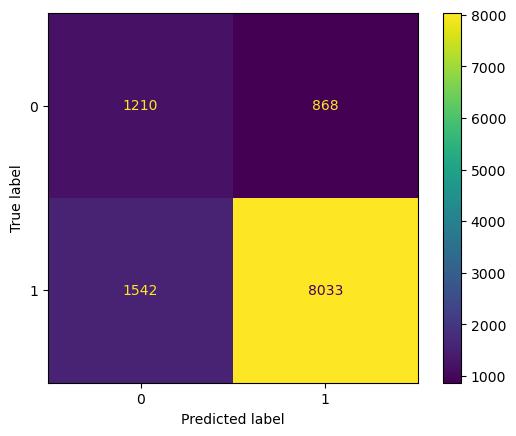

In [41]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=815)

metrics = []

conf_matrices = []

for i, (train_idx, test_idx) in enumerate(kfold.split(df_train[predictors], df_train.IN_LEAGUE_NEXT)):
    #grab the raw training data and test data for this CV fold
    X_tt  = df_train[predictors].iloc[train_idx]
    y_tt  = df_train.IN_LEAGUE_NEXT.iloc[train_idx]
    X_val = df_train[predictors].iloc[test_idx]
    y_val = df_train.IN_LEAGUE_NEXT.iloc[test_idx]

    #resample the training data using SMOTE
    smote = SMOTE(random_state=5)
    X_tt_re, y_tt_re = smote.fit_resample(X_tt, y_tt)

    #train the model
    tree = Pipeline([("scale", StandardScaler()), ("dt", DecisionTreeClassifier(max_depth=best_max_depth))])
    tree.fit(X_tt_re, y_tt_re)
    
    #get prediction and balanced accuracy scores for validation set
    pred = tree.predict(X_val)

    #compute metrics and append them to list
    metrics.append(compute_metrics(y_val, pred))

    #compute confusion matrix and append it to a list
    conf_matrices.append(confusion_matrix(y_val, pred))

    print(f"CV fold {i} complete")

#print CV averaged metrics
avg_bal_acc, avg_prec, avg_recall, avg_npv, avg_spec = np.mean(np.array(metrics), axis=0)
full_conf_matrix                                     = np.sum(conf_matrices, axis=0)

print("\n" + "Metrics for the SMOTE Naive Bayes Model")
print(f"Avg bal. accuracy: {avg_bal_acc:.3f}")
print(f"Avg precision:     {avg_prec:.3f}")
print(f"Avg recall:        {avg_recall:.3f}")
print(f"Avg NPV:           {avg_npv:.3f}")
print(f"Avg specificity:   {avg_spec:.3f}")

ConfusionMatrixDisplay(full_conf_matrix).plot()

### Decision Tree Classifier performs worse than logistic regression and LDA.

The balanced accuracy is about 5% lower for the decision tree classifier, and the NPV is appreciably worse (so the decision tree classifier has far more FNs).